http://neuralensemble.org/docs/PyNN/examples/VAbenchmarks.html


# balanced network

In [1]:
from pyNN.utility import ProgressBar, init_logging, normalized_filename
from pyNN.random import NumpyRNG, RandomDistribution

import pyNN.nest as sim

init_logging(None, debug=False)

# === Define parameters ========================================================

threads  = 1
rngseed  = 98765
parallel_safe = True

n        = 4000  # number of cells
r_ei     = 4.0   # number of excitatory cells:number of inhibitory cells
pconn    = 0.01  # connection probability
stim_dur = 50.   # (ms) duration of random stimulation
rate     = 10.  # (Hz) frequency of the random stimulation

dt       = 0.1   # (ms) simulation timestep
tstop    = 1000  # (ms) simulaton duration
delay    = 0.2
n_record = 40
# Cell parameters
area     = 20000. # (µm²)
tau_m    = 20.    # (ms)
cm       = 1.     # (µF/cm²)
g_leak   = 5e-5   # (S/cm²)
E_leak   = -60.  # (mV)
v_thresh = -50.   # (mV)
v_reset  = -60.   # (mV)
t_refrac = 5.     # (ms) (clamped at v_reset)
v_mean   = -60.   # (mV) 'mean' membrane potential, for calculating CUBA weights
tau_exc  = 5.     # (ms)
tau_inh  = 10.    # (ms)

# Synapse parameters
Gexc = 4.     # (nS)
Ginh = 51.    # (nS)
Erev_exc = 0.     # (mV)
Erev_inh = -80.   # (mV)

### what is the synaptic delay???

# === Calculate derived parameters =============================================

area  = area*1e-8                     # convert to cm²
cm    = cm*area*1000                  # convert to nF
Rm    = 1e-6/(g_leak*area)            # membrane resistance in MΩ
assert tau_m == cm*Rm                 # just to check
n_exc = int(round((n*r_ei/(1+r_ei)))) # number of excitatory cells
n_inh = n - n_exc                     # number of inhibitory cells
celltype = sim.IF_cond_exp
w_exc    = Gexc*1e-3              # We convert conductances to uS
w_inh    = Ginh*1e-3

# === Build the network ========================================================
extra = {'threads' : threads,
         'filename': "va.xml",
         'label': 'VA'}

cell_params = {
    'tau_m'      : tau_m,    'tau_syn_E'  : tau_exc,  'tau_syn_I'  : tau_inh,
    'v_rest'     : E_leak,   'v_reset'    : v_reset,  'v_thresh'   : v_thresh,
    'cm'         : cm,       'tau_refrac' : t_refrac}

cell_params['e_rev_E'] = Erev_exc
cell_params['e_rev_I'] = Erev_inh

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/__init__.py:53: UserWarning:Unable to install NEST extensions. Certain models may not be available.


## original 

In [2]:
node_id = sim.setup(timestep=dt, min_delay=delay, max_delay=1.0, **extra)
num_process = sim.num_processes()

print("%s Creating cell populations..." % node_id)

# create a single population of neurons, and then use population views to define
# excitatory and inhibitory sub-populations
all_cells = sim.Population(n_exc + n_inh, celltype(**cell_params), label="All Cells")
exc_cells = all_cells[:n_exc]
exc_cells.label = "Excitatory cells"
inh_cells = all_cells[n_exc:]
inh_cells.label = "Inhibitory cells"

ext_stim = sim.Population(20, sim.SpikeSourcePoisson(rate=rate, duration=stim_dur), label="expoisson")
rconn = 0.05
ext_conn = sim.FixedProbabilityConnector(rconn)
ext_syn = sim.StaticSynapse(weight=0.1)

print("%s Initialising membrane potential to random values..." % node_id)
rng = NumpyRNG(seed=rngseed, parallel_safe=parallel_safe)
uniformDistr = RandomDistribution('uniform', low=v_reset, high=v_thresh, rng=rng)
all_cells.initialize(v=uniformDistr)

print("%s Connecting populations..." % node_id)
progress_bar = ProgressBar(width=100)
connector = sim.FixedProbabilityConnector(pconn, rng=rng, callback=progress_bar)
exc_syn = sim.StaticSynapse(weight=w_exc, delay=delay)
inh_syn = sim.StaticSynapse(weight=w_inh, delay=delay)

connections = {}
connections['exc'] = sim.Projection(exc_cells, all_cells, connector, exc_syn, receptor_type='excitatory')
connections['inh'] = sim.Projection(inh_cells, all_cells, connector, inh_syn, receptor_type='inhibitory')
connections['ext'] = sim.Projection(ext_stim, all_cells, ext_conn, ext_syn, receptor_type='excitatory')

# === Setup recording ==========================================================
print("%s Setting up recording..." % node_id)
all_cells.record('spikes')
exc_cells[:n_record].record(['v', 'gsyn_exc', 'gsyn_inh'])

# === Run simulation ===========================================================
print("%d Running simulation..." % node_id)
sim.run(tstop)

E_count = exc_cells.mean_spike_count()
I_count = inh_cells.mean_spike_count()

n_connections = "%d e→e,i  %d i→e,i" % (connections['exc'].size(),
                                      connections['inh'].size())

print("\n--- Vogels-Abbott Network Simulation ---")
print("Number of Neurons      : %d" % n)
print("Number of Synapses     : %s" % n_connections)
print("Excitatory conductance : %g nS" % Gexc)
print("Inhibitory conductance : %g nS" % Ginh)
print("Excitatory rate        : %g Hz" % (E_count * 1000.0 / tstop,))
print("Inhibitory rate        : %g Hz" % (I_count * 1000.0 / tstop,))

# === Finished with simulator ==================================================

sim.end()

/usr/lib/python3.8/dist-packages/nest/lib/hl_api_helper.py:127: UserWarning:
ResetNetwork is deprecated and will be removed in NEST 3.0.
2020-12-02 11:27:41,897 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-02 11:27:41,903 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


0 Creating cell populations...
0 Initialising membrane potential to random values...
0 Connecting populations...
0 Setting up recording...########################################################################### ] 100%                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [3]:
all_spikes = all_cells.get_data()
exc_v = exc_cells.get_data()

/home/laurent/.local/lib/python3.8/site-packages/pyNN/recording/__init__.py:264: UserWarning:Recorded at least one spike after t_stop


In [4]:
all_spikes.annotations

{'size': 4000,
 'first_index': 0,
 'last_index': 4000,
 'first_id': 3,
 'last_id': 4002,
 'label': 'All Cells',
 'simulator': 'NEST',
 'dt': 0.1,
 'mpi_processes': 1}

In [5]:
all_spikes.segments[0]

Segment with 3 analogsignals, 4000 spiketrains
name: 'segment000'
description: 'Population "All Cells"\n    Structure   : {\'name\': \'Line\', \'parameters\': {\'dx\': 1.0, \'x0\': 0.0, \'y\': 0.0, \'z\': 0.0}}\n    Local cells : 4000\n    Cell type   : {\'name\': \'IF_cond_exp\', \'default_parameters\': {\'v_rest\': -65.0, \'cm\': 1.0, \'tau_m\': 20.0, \'tau_refrac\': 0.1, \'tau_syn_E\': 5.0, \'tau_syn_I\': 5.0, \'e_rev_E\': 0.0, \'e_rev_I\': -70.0, \'v_thresh\': -50.0, \'v_reset\': -65.0, \'i_offset\': 0.0}, \'default_initial_values\': {\'v\': -65.0, \'gsyn_exc\': 0.0, \'gsyn_inh\': 0.0}, \'parameters\': {\'v_rest\': <larray: base_value=-60.0 shape=(4000,) dtype=<class \'float\'>, operations=[]>, \'cm\': <larray: base_value=0.2 shape=(4000,) dtype=<class \'float\'>, operations=[]>, \'tau_m\': <larray: base_value=20.0 shape=(4000,) dtype=<class \'float\'>, operations=[]>, \'tau_refrac\': <larray: base_value=5.0 shape=(4000,) dtype=<class \'float\'>, operations=[]>, \'tau_syn_E\': <lar

In [6]:
exc_v.segments[0].analogsignals

[AnalogSignal with 40 channels of length 10001; units mV; datatype float64 
 name: 'v'
 annotations: {'source_population': 'All Cells',
   'source_ids': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
          20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
          37, 38, 39, 40, 41, 42])}
 sampling rate: 10.0 1/ms
 time: 0.0 ms to 1000.1 ms,
 AnalogSignal with 40 channels of length 10001; units uS; datatype float64 
 name: 'gsyn_exc'
 annotations: {'source_population': 'All Cells',
   'source_ids': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
          20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
          37, 38, 39, 40, 41, 42])}
 sampling rate: 10.0 1/ms
 time: 0.0 ms to 1000.1 ms,
 AnalogSignal with 40 channels of length 10001; units uS; datatype float64 
 name: 'gsyn_inh'
 annotations: {'source_population': 'All Cells',
   'source_ids': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11

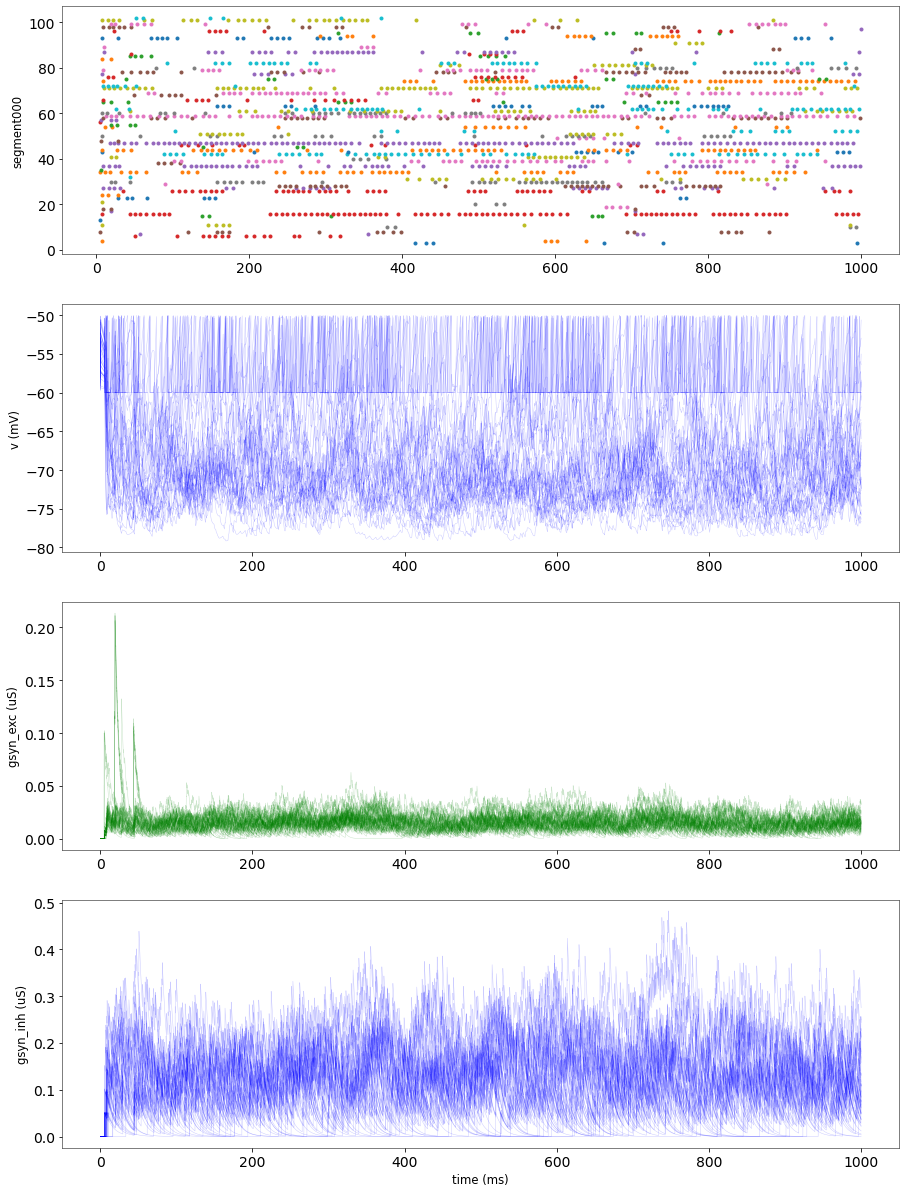

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def plot(signal, spikes, alpha=.2):
    fig_settings = {
        'lines.linewidth': 0.5,
        'axes.linewidth': 0.5,
        'axes.labelsize': 'small',
        'legend.fontsize': 'small',
        'font.size': 14
    }
    plt.rcParams.update(fig_settings)

    #n_panels = sum(a.shape[1] for a in signal.segments[0].analogsignals) + 1
    n_panels = len(signal.segments[0].analogsignals) +1 
    fig, axs = plt.subplots(n_panels, 1, figsize=(15, 21))

    def plot_spiketrains(ax, segment):
        for spiketrain in segment.spiketrains[:100]:
            y = np.ones_like(spiketrain) * spiketrain.annotations['source_id']
            ax.plot(spiketrain, y, '.')
            ax.set_ylabel(segment.name)
            #plt.setp(plt.gca().get_xticklabels(), visible=False)

    def plot_signal(ax, signal, index, colour='b'):
        label = "Neuron %d" % signal.annotations['source_ids'][index]
        ax.plot(signal.times, signal[:, index], colour, label=label, alpha=alpha)
        ax.set_ylabel("%s (%s)" % (signal.name, signal.units._dimensionality.string))
        #plt.setp(plt.gca().get_xticklabels(), visible=False)
        #plt.legend()

    plot_spiketrains(axs[0], spikes.segments[0])
    #plot_spiketrains(axs[1], all_spikes.segments[0])
    for i_panel, array in enumerate(signal.segments[0].analogsignals):
        for i in range(array.shape[1]):
            ax = axs[i_panel+1]
            plot_signal(ax, array, i, colour='bg'[i_panel % 2])
    ax.set_xlabel("time (%s)" % array.times.units._dimensionality.string)
    #plt.setp(plt.gca().get_xticklabels(), visible=True)
    return fig, axs

fig, axs = plot(exc_v, all_spikes)

## Modifying connections

http://neuralensemble.org/docs/PyNN/connections.html


In [8]:
for pop in ['exc', 'ext', 'inh']:
    weights, delays = connections[pop].get(['weight', 'delay'], format='array')
    print(weights.shape, delays.shape)

(3200, 4000) (3200, 4000)
(20, 4000) (20, 4000)
(800, 4000) (800, 4000)


In [9]:
connections['exc']

Projection("Excitatory cells→All Cells")

In [10]:
connections

{'exc': Projection("Excitatory cells→All Cells"),
 'inh': Projection("Inhibitory cells→All Cells"),
 'ext': Projection("expoisson→All Cells")}

In [11]:
weights.shape

(800, 4000)

In [12]:
weights.sum(axis=0)

array([nan, nan, nan, ..., nan, nan, nan])

In [13]:
import numpy as np
exists = ~np.isnan(weights)

number of valid connections:

In [14]:
exists.sum(axis=0),exists.sum(axis=0).shape

(array([ 9, 10,  8, ..., 14,  6, 10]), (4000,))

In [15]:
weights[exists][:10], weights[exists].shape

(array([0.051, 0.051, 0.051, 0.051, 0.051, 0.051, 0.051, 0.051, 0.051,
        0.051]),
 (32011,))

In [16]:
weight_cp = weights.copy()
weight_cp[np.isnan(weights)] = 0.
weight_cp.sum(axis=0)

array([0.459, 0.51 , 0.408, ..., 0.714, 0.306, 0.51 ])

In [17]:
weights_norm = weights * weights[exists].mean() / weight_cp.sum(axis=0)

In [18]:
weight_cp = weights_norm.copy()
weight_cp[np.isnan(weights_norm)] = 0.

weight_cp.sum(axis=0)

array([0.051, 0.051, 0.051, ..., 0.051, 0.051, 0.051])

setting weights:

In [19]:
connections[pop].get?

Object `get` not found.


In [ ]:
connections[pop].get

In [20]:
connections[pop].get

<bound method Projection.get of Projection("Inhibitory cells→All Cells")>

In [21]:
c_inh = connections['inh']

In [22]:
c_inh.get('weight', format='array').shape

(800, 4000)

In [23]:
weight_cp.shape

(800, 4000)

In [24]:
c_inh.set(weight=weight_cp)

## applying that strategy 

In [25]:
node_id = sim.setup(timestep=dt, min_delay=delay, max_delay=1.0, **extra)
num_process = sim.num_processes()

print("%s Creating cell populations..." % node_id)

# create a single population of neurons, and then use population views to define
# excitatory and inhibitory sub-populations
all_cells = sim.Population(n_exc + n_inh, celltype(**cell_params), label="All Cells")
exc_cells = all_cells[:n_exc]
exc_cells.label = "Excitatory cells"
inh_cells = all_cells[n_exc:]
inh_cells.label = "Inhibitory cells"

ext_stim = sim.Population(20, sim.SpikeSourcePoisson(rate=rate, duration=stim_dur), label="expoisson")
rconn = 0.01
ext_conn = sim.FixedProbabilityConnector(rconn)
ext_syn = sim.StaticSynapse(weight=0.1)

print("%s Initialising membrane potential to random values..." % node_id)
rng = NumpyRNG(seed=rngseed, parallel_safe=parallel_safe)
uniformDistr = RandomDistribution('uniform', low=v_reset, high=v_thresh, rng=rng)
all_cells.initialize(v=uniformDistr)

print("%s Connecting populations..." % node_id)
progress_bar = ProgressBar(width=100)
connector = sim.FixedProbabilityConnector(pconn, rng=rng, callback=progress_bar)
exc_syn = sim.StaticSynapse(weight=w_exc, delay=delay)
inh_syn = sim.StaticSynapse(weight=w_inh, delay=delay)

connections = {}
connections['exc'] = sim.Projection(exc_cells, all_cells, connector, exc_syn, receptor_type='excitatory')
connections['inh'] = sim.Projection(inh_cells, all_cells, connector, inh_syn, receptor_type='inhibitory')
connections['ext'] = sim.Projection(ext_stim, all_cells, ext_conn, ext_syn, receptor_type='excitatory')

# normalizing weights
for pop in ['exc', 'inh']: # , 'ext'
    # weights, delays = connections[pop].get(['weight', 'delay'], format='array')
    weight = connections[pop].get('weight', format='array')
    print(pop, weight.shape)
    weight_cp = weight.copy()
    weight_cp[np.isnan(weight)] = 0.
    weight_norm = weight_cp * (weight[~np.isnan(weight)].mean()) / weight_cp.mean(axis=0)
    print(pop, weight_norm.shape)
    connections[pop].set(weight=weight_norm)
    
# === Setup recording ==========================================================
print("%s Setting up recording..." % node_id)
all_cells.record('spikes')
exc_cells[:n_record].record(['v', 'gsyn_exc', 'gsyn_inh'])

# === Run simulation ===========================================================
print("%d Running simulation..." % node_id)
sim.run(tstop)

E_count = exc_cells.mean_spike_count()
I_count = inh_cells.mean_spike_count()

n_connections = "%d e→e,i  %d i→e,i" % (connections['exc'].size(),
                                      connections['inh'].size())

print("\n--- Vogels-Abbott Network Simulation ---")
print("Number of Neurons      : %d" % n)
print("Number of Synapses     : %s" % n_connections)
print("Excitatory conductance : %g nS" % Gexc)
print("Inhibitory conductance : %g nS" % Ginh)
print("Excitatory rate        : %g Hz" % (E_count * 1000.0 / tstop,))
print("Inhibitory rate        : %g Hz" % (I_count * 1000.0 / tstop,))

# === Finished with simulator ==================================================

sim.end()

2020-12-02 11:28:45,362 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-02 11:28:45,369 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


0 Creating cell populations...
0 Initialising membrane potential to random values...
0 Connecting populations...
exc (3200, 4000)#################################################################################### ] 100%                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

<ipython-input-25-b34227efc04c>:42: RuntimeWarning:invalid value encountered in true_divide


0 Setting up recording...
0 Running simulation...

--- Vogels-Abbott Network Simulation ---
Number of Neurons      : 4000
Number of Synapses     : 128066 e→e,i  32011 i→e,i
Excitatory conductance : 4 nS
Inhibitory conductance : 51 nS
Excitatory rate        : 35.3403 Hz
Inhibitory rate        : 35.99 Hz


/home/laurent/.local/lib/python3.8/site-packages/pyNN/recording/__init__.py:264: UserWarning:Recorded at least one spike after t_stop


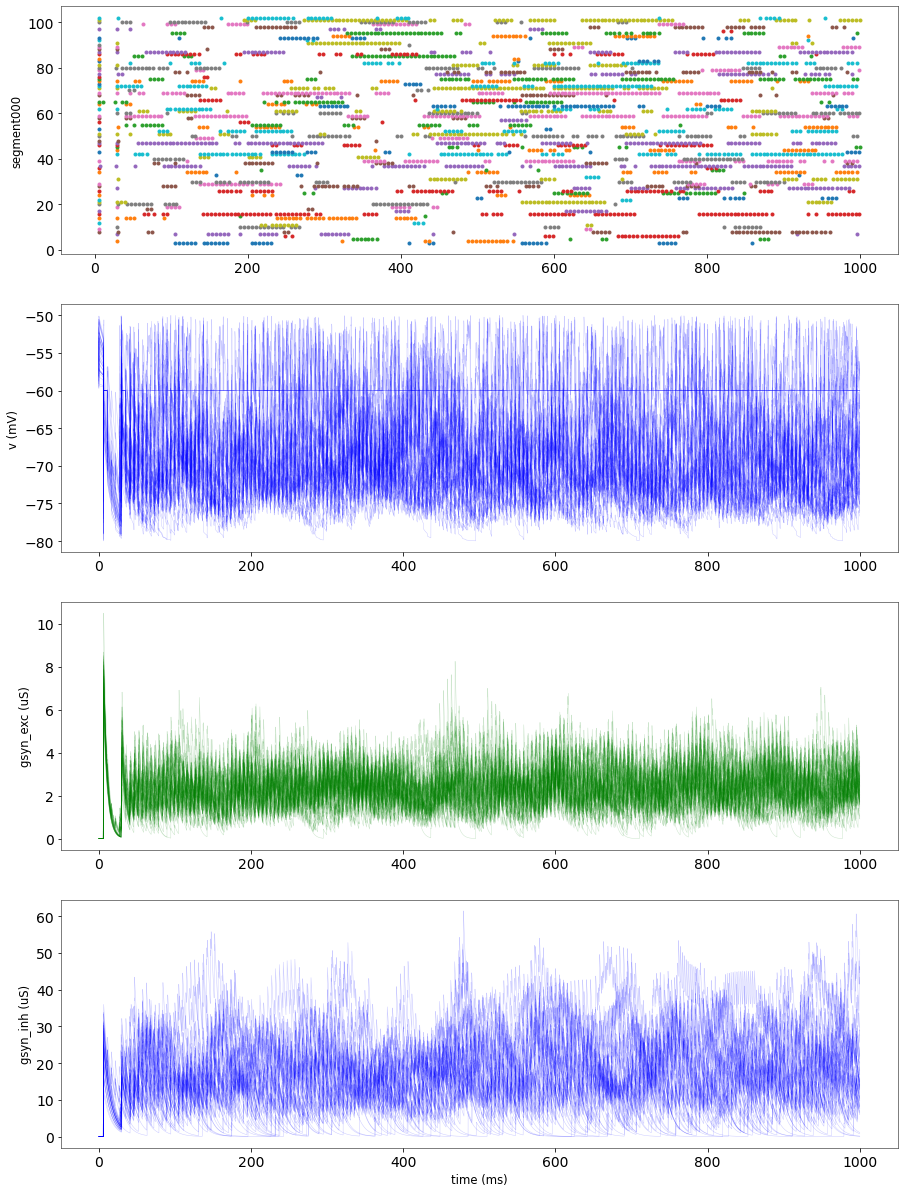

In [26]:
all_spikes = all_cells.get_data()
exc_v = exc_cells.get_data()

fig, axs = plot(exc_v, all_spikes)